In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import operator
import collections

import networkx as nx
from community import community_louvain
from networkx.algorithms.community.centrality import girvan_newman

from collections import Counter, defaultdict
from operator import itemgetter
from tqdm import tqdm

Loading the adjacency matrix and the sampled data

In [2]:
adjacency_matrix = np.load('adjacency_matrix.npy')

data_recipe = pd.read_json('processed_data.json').reset_index(drop=True)

In [3]:
data_recipe.head(5)

,directions,fat,date,categories,calories,protein,rating,title,ingredients,sodium
0,[Position rack in center of oven; preheat to 3...,27,2004-08-20 04:00:00,"[Cake, Food Processor, Mixer, Cheese, Dairy, E...",479,7,3.750,"Christmas Cranberry, Pear and Walnut Torte wit...","[orange, puree, cheese-orange, egg, frosting, ...",204
1,[Butter 11x7x2-inch glass baking dish. Sauté s...,46,2004-08-20 04:00:00,"[Onion, Pepper, Pork, Breakfast, Sauté, Parmes...",606,22,3.125,"Breakfast Polenta with Sausage, Onion and Peppers","[sausage, casing, bell, onion, cornmeal, butte...",968
2,"[Stir together butter, horseradish, dill, shal...",100,2007-05-17 19:43:26,"[Fish, Herb, Backyard BBQ, Dinner, Horseradish...",1305,92,4.375,Grilled Boneless Salmon Steaks with Horseradis...,"[horseradish, shallot, oil, string, salmon, bu...",923
3,[Cook bacon in a deep 12-inch heavy skillet ov...,71,2004-08-20 04:00:00,"[Chicken, Garlic, Braise, Vinegar, Bacon, Fall...",1086,81,3.750,"Braised Chicken with Shallots, Garlic, and Bal...","[shallot, slice, piece, head, strip, 1/2-lb, b...",485
4,[Cut off all peel and white pith from 3 blood ...,0,2007-10-02 19:13:35,"[Sauce, Food Processor, Side, No-Cook, Christm...",255,2,4.375,Cranberry and Blood Orange Relish,"[blood, orange, cranberry, sugar]",2


Plotting the adjacency matrix to see sparsity pattern

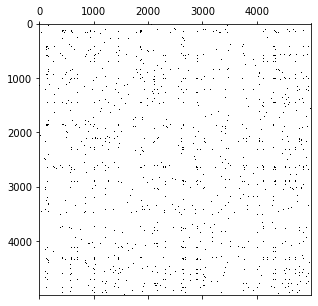

In [4]:
plt.figure(figsize=(5,5))
plt.spy(adjacency_matrix)
plt.show()

In [5]:
def describe_graph(G):
    """
    Helper function for printing various graph properties.
    
    Parameters
    ----------
    
    G: NetworkX graph object
        Graph
    """
    print(nx.info(G))
    if nx.is_connected(G):
        print("Average shortest path length: %.4f" %nx.average_shortest_path_length(G))
        print("Diameter: %.4f" %nx.diameter(G)) # Longest shortest path
    else:
        print("Graph is not connected")
        print("Diameter and Avg shortest path length are not defined!")
    print("Sparsity: %.4f" %nx.density(G))  # #edges/#edges-complete-graph
    # #closed-triplets(3*#triangles)/#all-triplets
    print("Global clustering coefficient aka Transitivity: %.4f" %nx.transitivity(G))

Let's create a graph object from our adjacency matrix

In [6]:
graph = nx.from_numpy_array(adjacency_matrix)

In [7]:
describe_graph(graph)

Name: 
Type: Graph
Number of nodes: 5000
Number of edges: 230352
Average degree:  92.1408
Graph is not connected
Diameter and Avg shortest path length are not defined!
Sparsity: 0.0184
Global clustering coefficient aka Transitivity: 0.3363


Creating dictionaries which will map nodes to the corresponding dish names and vice versa

In [8]:
node_label_mapping = dict(zip(range(5000), data_recipe.title))
label_node_mapping = dict(zip(data_recipe.title,range(5000)))

Now, let's add attributes to our graph's nodes

In [9]:
nx.set_node_attributes(graph, data_recipe['protein'].to_dict(), 'protein')
nx.set_node_attributes(graph, data_recipe['fat'].to_dict(), 'fat')
nx.set_node_attributes(graph, data_recipe['sodium'].to_dict(), 'sodium')
nx.set_node_attributes(graph, data_recipe['calories'].to_dict(), 'calories')
nx.set_node_attributes(graph, data_recipe['rating'].to_dict(), 'rating')

An example of a node with its corresponding dish title

In [10]:
print(node_label_mapping[0])
print(graph.node[0])

Christmas Cranberry, Pear and Walnut Torte with Cream Cheese-Orange Frosting
{'protein': 7, 'fat': 27, 'sodium': 204, 'calories': 479, 'rating': 3.75}


In [11]:
def visualize_graph(G, signal, with_labels=False, k=None, alpha=1.0, node_shape='o'):
    """
    Helper function for visualizing signal on the graph.

    Parameters
    ----------

    G: NetworkX graph object
        Graph
    
    signal: string
        Node attribute to be used as a graph signal
    
    with_labels: boolean
        Node label
    
    k: float
        Optimal distance between nodes.  If None the distance is set to
        1/sqrt(n) where n is the number of nodes.  Increase this value
        to move nodes farther apart.
        
    alpha: float
        The edge transparency
    
    node_shape: string
        The shape of the node.  Specification is as matplotlib.scatter
        marker, one of 'so^>v<dph8'
    """
    plt.figure(figsize=(15,8))
    plt.title(signal + ' as a signal on the graph')
    pos = nx.spring_layout(G, k=k)
    if with_labels:
        lab = nx.draw_networkx_labels(G, pos, labels=dict([(n, n) for n in G.nodes()]))
    ec = nx.draw_networkx_edges(G, pos, alpha=alpha)
    nc = nx.draw_networkx_nodes(G, pos, nodelist=G.nodes(), node_color=[G.nodes[n][signal] for n in G.nodes()], node_shape=node_shape)
    plt.colorbar(nc)
    plt.axis('off')

Having the graph ready, let's visualize our features/attributes (e.g. rating, protein) as graph signals

/Users/davitmartirosyan/anaconda3/envs/NTDS/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


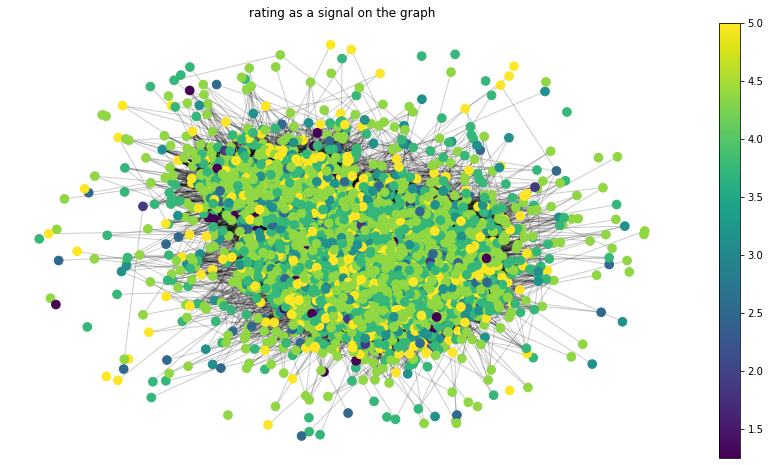

In [12]:
visualize_graph(graph,'rating', k=0.1, alpha=0.2, node_shape='.')

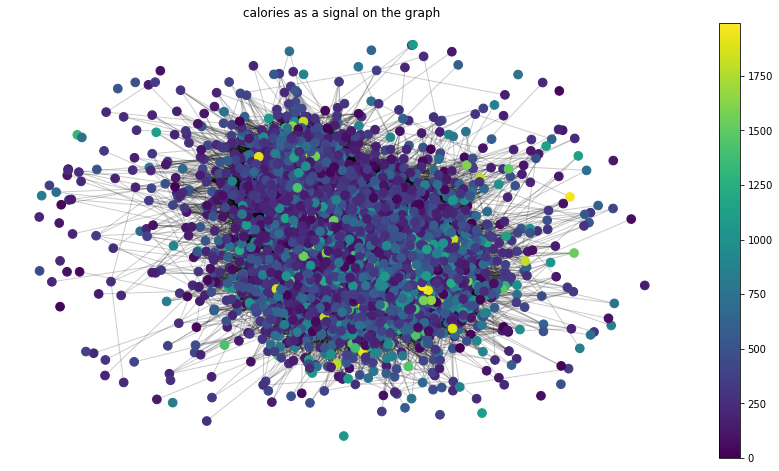

In [13]:
visualize_graph(graph,'calories', k=0.1, alpha=0.2, node_shape='.')

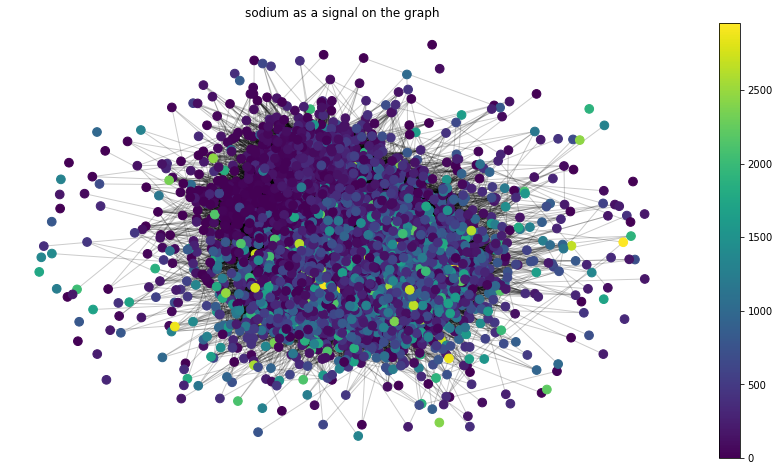

In [14]:
visualize_graph(graph,'sodium', k=0.1, alpha=0.2, node_shape='.')

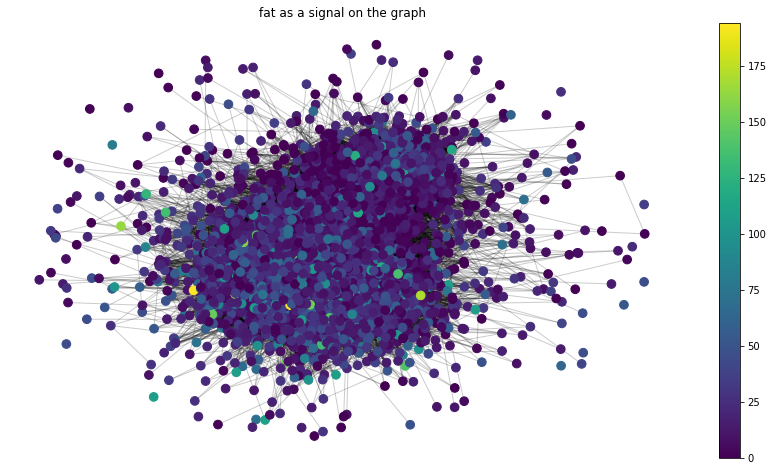

In [15]:
visualize_graph(graph,'fat', k=0.1, alpha=0.2, node_shape='.')

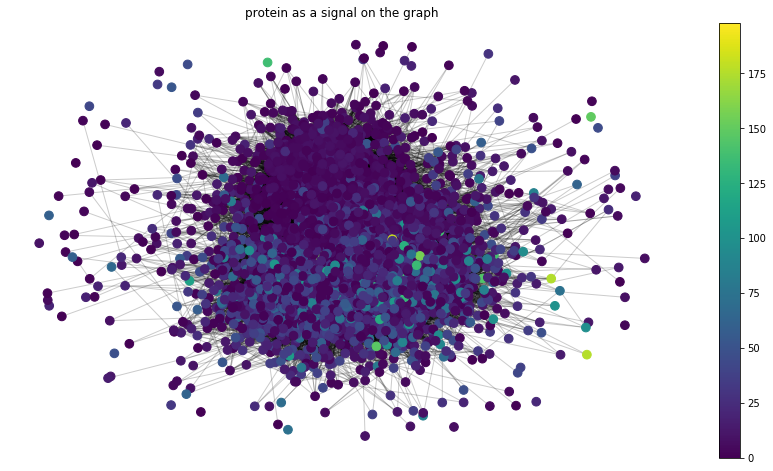

In [16]:
visualize_graph(graph,'protein', k=0.1, alpha=0.2, node_shape='.')

One of the interesting questions that one may think of is the following: **_Do similar recipes tend to have similar ratings?_**

Given our graph, to answer this question we can simply calculate attribute assortativity coefficient for 'rating', which measures the similarity of connections in the graph with respect to the 'rating' attribute.

In [17]:
nx.attribute_assortativity_coefficient(graph, 'rating')

0.01129789184202755

As we can see the number is quite small indicating that in general similar recipes do not have similar ratings.

### Community detection

Given our graph, it is extremely interesting to investigate the different clusters and their properties it contains. For this purpose we are going to use the **_Louvain method_**, which is one of the most famous algorithms for commuity detection.

In [18]:
partition = community_louvain.best_partition(graph, random_state=42)

In [19]:
print('Total number of clusters found: {}'.format(max(partition.values())+1))

Total number of clusters found: 33


Let's add as a node attribute the cluster label obtained from the partition by the Louvain method

In [20]:
nx.set_node_attributes(graph, partition, 'cluster')

Now, let's visualize the different clusters

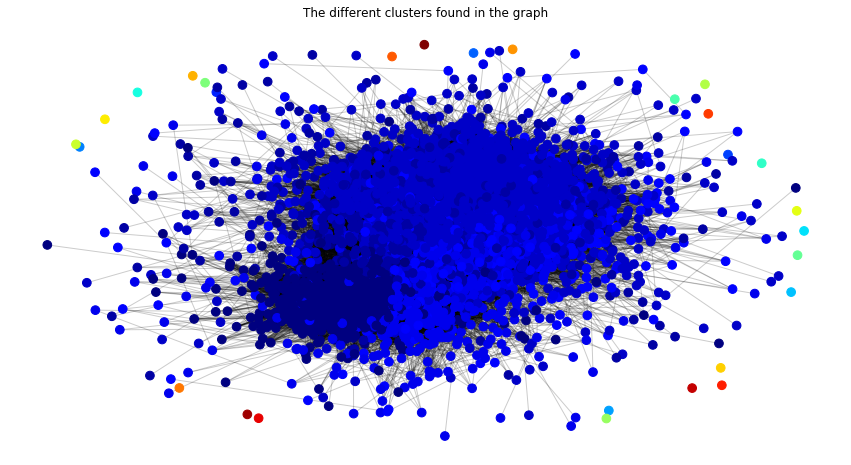

In [21]:
plt.figure(figsize=(15,8))
plt.title('The different clusters found in the graph')
pos = nx.spring_layout(graph,k=0.1)
ec = nx.draw_networkx_edges(graph, pos, alpha=0.2)
nc = nx.draw_networkx_nodes(graph, pos, nodelist=graph.nodes(), node_color=[graph.nodes[n]['cluster'] for n in graph.nodes()], 
                            with_labels=False, node_shape='.', cmap=plt.cm.jet)
plt.axis('off')
plt.show()

Let's print the number of nodes in each cluster.

In [22]:
Counter(partition.values())

Counter({0: 1027,
         1: 627,
         2: 2365,
         3: 530,
         4: 423,
         5: 1,
         6: 1,
         7: 1,
         8: 1,
         9: 1,
         10: 1,
         11: 1,
         12: 1,
         13: 1,
         14: 1,
         15: 1,
         16: 1,
         17: 1,
         18: 1,
         19: 1,
         20: 1,
         21: 1,
         22: 1,
         23: 1,
         24: 1,
         25: 1,
         26: 1,
         27: 1,
         28: 1,
         29: 1,
         30: 1,
         31: 1,
         32: 1})

Let's take the big clusters and investigate the properties shared within each individual cluster.

In [23]:
# Take all the nodes that belong to the 0th, 1st, 2nd, 3rd and 4th clusters respectively
cluster_0 = [k for k in graph.nodes if partition[k] == 0]
cluster_1 = [k for k in graph.nodes if partition[k] == 1]
cluster_2 = [k for k in graph.nodes if partition[k] == 2]
cluster_3 = [k for k in graph.nodes if partition[k] == 3]
cluster_4 = [k for k in graph.nodes if partition[k] == 4]

In [24]:
for each in cluster_0:
        print(node_label_mapping[each])

Christmas Cranberry, Pear and Walnut Torte with Cream Cheese-Orange Frosting
Passion Fruit Mousses with Raspberry Swirl
Apple Pie with Oat Streusel
Frontera Grill's Chocolate Pecan Pie with Coffee Whipped Cream
Superb English Plum Pudding
Espresso-Hazelnut Cheesecake
Thin Apple Tarts
Trio of Gelati
Honey Custard in Phyllo Pastry
Raspberry and Peach Parfait Cake
Chocolate and Coconut Pecan Tart
Ben's Chunky Applesauce
Hazelnut Linzer Cookies with Blackberry Jam
Strawberry-Topped Cheesecake with Graham Cracker Crust
Sage Buttermilk Biscuits with Sausage and Cheddar
Butterscotch Budino with Whipped Crème Fraîche
Mirabelle Ginger Tart
Plum Hazelnut Torte
Dried Cranberry, Walnut, and Lemon Scones
Pear Küchen
Gingered Squash and Ham Soup with Cornmeal Dumplings
Mixed-Berry Crisp
Lemon Meringue Buttercream
Raspberry Cream Cheese Brownies
Cappuccino Brownies
Pear Clafoutis
Prune Armagnac Gingerbread
Rhubarb Roulade
Individual Raspberry and Banana Trifles
Cranberry and Pumpkin Pie Spice Tea Cak

As we can notice, this cluster is comprised of mainly deserts (e.g. cakes, chocolates, ice-cream, etc.)

In [ ]:
# def print_top_10_categories(cluster):
#     categories = []
#     for elem in data_recipe.iloc[cluster].categories:
#         categories.extend(elem)

#     count = collections.Counter(categories)

#     print(sorted(count, key=count.get, reverse=True)[:10]) 


# print_top_10_categories(cluster_0)

In [ ]:
for each in cluster_1:
        print(node_label_mapping[each])

In [ ]:
for each in cluster_2:
        print(node_label_mapping[each])

In [ ]:
#The third cluster contains more elaborate dishes, usually containing meat/chicken/fish. As a matter of fact, a big proportion of them have "gourmet" category. These recipes represent main dishes, hence we notice that it has the highest average amounts of calories, protein, fat between the five clusters.

In [ ]:
for each in cluster_3:
        print(node_label_mapping[each])

In [ ]:
#This cluster contains the deserts. More than 70% of the dishes have the labels "desert" and "bake" in the categories. Some other frequent ones are "chocolate", "vegetarian", "milk", etc.

In [ ]:
for each in cluster_4:
        print(node_label_mapping[each])

We notice that the first cluster contains mainly simple dishes, which do not require alot of preparation and usually do not contain meat/chicken. They are mainly soups, appetizers and vegetarian simple dishes.

The second cluster contains mainly drinks. If we look at the categories present in recipes in this cluster, we find many that contain fruits, alcohol (like rhum, liqueur etc.) or juice labels. On another hand, if we compare the average amount of proteins for example in the four main clusters, we can clearly see that this cluster has lower amounts of protein and fat, which is also coherent.

### Simple recommender system based on KNN

In [25]:
def get_top_n_recs(dish_list, k, n):
    """
    Give top-n recommendations given a list of dishes.

    Parameters
    ----------

    dish_list: list
        List of dish names
        
    n: int
        Number of recommendations to show
    
    k: int 
        Number of neighbors to use
    """
    
    dish_list = [label_node_mapping[each] for each in dish_list]
    
    d = {elem: graph.node[elem]['rating'] for elem in dish_list}
    k_neighbours = [each[0] for each in sorted(d.items(), key=itemgetter(1), reverse=True)[:k]]
    candidates = defaultdict(float)
    
    for each in k_neighbours:
        for i, elem in enumerate(adjacency_matrix[each]):
            candidates[i]+=elem

    print('The top {} recommendations are the following:'.format(n))
    count = 1
    for index, score in sorted(candidates.items(), key=itemgetter(1), reverse=True):
        print(node_label_mapping[index])
        if count >= n:
            break
        count += 1

In [27]:
# This list includes are deserts, so we expect to get recommendations that are also deserts (e.g. cake, ice-cream)
dish_list = ['Chocolate, Cherry and Marsala Cassata', 'Ginger Pudding',
             'Trifle with Strawberries and Caramel-Coated Bananas', 'Thin Apple Tarts',
             'Shortbread Cookies', 'Burnt-Caramel Custards', 'Peach White-Wine Sangria']

get_top_n_recs(dish_list,k=5,n=5)

The top 5 recommendations are the following:
Sour Cream Ice Cream
Raspberry and Brown Sugar Custard Tart
Butter Pie Crust Dough
Burnt Caramel Ice Cream
Nectarine Lime Curd Tart with a Brown-Sugar Crust


As we can see the recommendations are quite adequate.

In [28]:
# This list includes drinks, so we expect to get recommendations that are drinks
dish_list = ['Crushed-Mint Lemonade','Ginger-Honey Lemonade','Papaya Smoothie',
            'Oranges with Pomegranate Molasses and Honey','Pine Nut Brittle','Sweet Avocado Mousse',
            'Gimlet','Campari Citrus Cooler','Tangerine Granita']

get_top_n_recs(dish_list,k=5,n=5)

The top 5 recommendations are the following:
Iced Vodka with Cucumber, Lemon, and Mint
Florida Punch
Iced Mint Tea
Butter Pie Crust Dough
Sidecar


As we can see the recommendations are again quite good.

Let's see what recommendations we get if we include both drinks and deserts.

In [30]:
dish_list = ['Crushed-Mint Lemonade','Ginger-Honey Lemonade','Ginger-Honey Lemonade','Papaya Smoothie',
            'Oranges with Pomegranate Molasses and Honey','Pine Nut Brittle','Sweet Avocado Mousse',
            'Gimlet','Campari Citrus Cooler','Tangerine Granita','Chocolate, Cherry and Marsala Cassata', 
             'Ginger Pudding','Trifle with Strawberries and Caramel-Coated Bananas', 'Thin Apple Tarts',
             'Shortbread Cookies', 'Burnt-Caramel Custards', 'Peach White-Wine Sangria']

get_top_n_recs(dish_list,k=10,n=5)

The top 5 recommendations are the following:
Butter Pie Crust Dough
Classic Sour Cherry Pie with Lattice Crust
Florida Punch
Peaches in Ginger Syrup
Cantaloupe Granita


As we can see we have recommendations that are both drinks such as Cantaloupe Granita and deserts like Butter Pie Crust Dough, which is exciting!

# DRAFT

What are the main nutritional factors affecting people’s culinary preferences? TBC...

In [ ]:
def rating_to_category(rating):
    if rating < 3:
        return 0 # low rating
    elif rating < 4:
        return 1 # medium rating
    else:
        return 2 # high rating

In [ ]:
data_recipe['rating_categories'] = data_recipe['rating'].apply(rating_to_category)

In [ ]:
data_recipe.rating_categories.value_counts()

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

from scipy.sparse import csgraph

In [ ]:
features = data_recipe[['fat','calories','protein','sodium']]
labels = data_recipe.rating_categories

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

In [ ]:
X_train.shape,X_test.shape,X_val.shape

In [ ]:
C = np.logspace(0,6)
scores = []

for c in C:
    model_logit = LogisticRegression(solver='lbfgs',multi_class='multinomial',max_iter=1000, C=c, random_state=42)
    model_logit.fit(X_train,y_train)
    scores.append(model_logit.score(X_val,y_val))

In [ ]:
c_best = C[np.argmax(scores)]
model_logit_best = LogisticRegression(solver='lbfgs',multi_class='multinomial',max_iter=1000, C=c_best, random_state=42)
model_logit_best.fit(X_train,y_train)

In [ ]:
train_acc =  model_logit_best.score(X_train,y_train)
val_acc =  model_logit_best.score(X_val,y_val)
test_acc =  model_logit_best.score(X_test,y_test)

print('Train accuracy {:.4f} | Validation accuracy {:.4f} | Test accuracy {:.4f}'.format(train_acc, val_acc, test_acc))

In [ ]:
def spectral_decomposition(laplacian: np.ndarray):
    """ Return:
        lamb (np.array): eigenvalues of the Laplacian
        U (np.ndarray): corresponding eigenvectors.
    """
    eig_val, eig_vec = np.linalg.eigh(laplacian)
    idx = eig_val.argsort() 
    lamb = eig_val[idx]
    U = eig_vec[:,idx]
    return lamb,U

In [ ]:
laplacian = csgraph.laplacian(adjacency_matrix,normed=True)
lam, U = spectral_decomposition(laplacian)
lam_max = np.max(lam)

In [ ]:
plt.figure(figsize=(5,5))
plt.plot(lam)
plt.xlabel('Index')
plt.ylabel('Eigenvalue')
plt.title('Eigenvalues $L_{norm}$')
plt.show()

In [ ]:
ideal_filter = np.ones((5000,))
ideal_filter[lam >= 0.2] = 0

In [ ]:
def fit_polynomial(lam: np.ndarray, order: int, spectral_response: np.ndarray):
    """ Return an array of polynomial coefficients of length 'order'."""
    V = np.vander(lam,N=order,increasing=True)
    return np.linalg.lstsq(V,spectral_response)[0]

In [ ]:
def polynomial_graph_filter_response(coeff: np.array, lam: np.ndarray):
    """ Return an array of the same shape as lam.
        response[i] is the spectral response at frequency lam[i]. """
    V = np.vander(lam,N=coeff.shape[0],increasing=True)
    return np.dot(V,coeff)

In [ ]:
def polynomial_graph_filter(coeff: np.array, laplacian: np.ndarray):
    """ Return the laplacian polynomial with coefficients 'coeff'. """
    L_k = [np.linalg.matrix_power(laplacian,k) for k in range(len(coeff))]
    res = np.zeros(laplacian.shape)
    for index,each in enumerate(L_k):
        res+=coeff[index]*each
    return res

In [ ]:
order = 7

coeff = fit_polynomial(lam, order, ideal_filter)
graph_filter = polynomial_graph_filter(coeff, laplacian)

In [ ]:
plt.plot(lam, ideal_filter)
plt.plot(lam, polynomial_graph_filter_response(coeff, lam))
plt.legend(['Ideal', 'Polynomial'])
plt.xlabel('$\lambda$')
plt.ylabel('Spectral response')

In [ ]:
new_features = graph_filter @ features

X_train, X_test, y_train, y_test = train_test_split(new_features, labels, test_size=0.2, random_state=42)

X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

In [ ]:
C = np.logspace(0,6)
scores = []

for c in C:
    model_logit = LogisticRegression(solver='lbfgs',multi_class='multinomial',max_iter=1000, C=c, random_state=42)
    model_logit.fit(X_train,y_train)
    scores.append(model_logit.score(X_val,y_val))

In [ ]:
c_best = C[np.argmax(scores)]
model_logit_best = LogisticRegression(solver='lbfgs',multi_class='multinomial',max_iter=1000, C=c_best, random_state=42)
model_logit_best.fit(X_train,y_train)

In [ ]:
train_acc =  model_logit_best.score(X_train,y_train)
val_acc =  model_logit_best.score(X_val,y_val)
test_acc =  model_logit_best.score(X_test,y_test)

print('Train accuracy {:.4f} | Validation accuracy {:.4f} | Test accuracy {:.4f}'.format(train_acc, val_acc, test_acc))

In [ ]:
model_logit_best.predict_proba(X_train)